<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/single_variable_Resid_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/podobongbong/the_project.git

Cloning into 'the_project'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 732.48 KiB | 2.09 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
import os
os.chdir('/content/the_project') # Changed directory to where the CSV file likely exists
import pandas as pd

# Updated path to reflect the CSV's location in the cloned repo
data = pd.read_csv('energy.csv')

data.columns = ['year','city','district','type','jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

#주택용
data = data[data['type']=='주택용']

monthly_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
aggregated_data = data.groupby(['year','city'])[monthly_columns].sum().reset_index()

# Updated path for the output CSV as well
aggregated_data.to_csv('total_aggregated_city_energy.csv', index=False)


In [ ]:
#%% DATA PREP
import numpy as np
from sklearn.preprocessing import MinMaxScaler
seoul_data = aggregated_data[aggregated_data['city'] == '서울특별시'].drop(columns=['city']).set_index('year')
busan_data = aggregated_data[aggregated_data['city'] == '부산광역시'].drop(columns=['city']).set_index('year')

energy_data_seoul = seoul_data.values.flatten()
energy_data_busan = busan_data.values.flatten()

# Normalize the data using MinMaxScaler
scaler_seoul = MinMaxScaler()  # Use separate scaler for Seoul
scaler_busan = MinMaxScaler()  # Use separate scaler for Busan
# Normalize Seoul data
energy_data_seoul_scaled = scaler_seoul.fit_transform(energy_data_seoul.reshape(-1, 1)).flatten()

# Normalize Busan data
energy_data_busan_scaled = scaler_busan.fit_transform(energy_data_busan.reshape(-1, 1)).flatten()



In [ ]:
#%% SLIDING WINDOW
# Function to create sliding window samples
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # Take the previous 'window_size' months
        y.append(data[i])  # The target is the next month's consumption
    return np.array(X), np.array(y)

WINDOW_SIZE = 12
TOTAL_MONTHS = 240

# Create sliding window samples for Seoul and Busan
X_seoul, y_seoul = create_sliding_window(energy_data_seoul_scaled, WINDOW_SIZE)
X_busan, y_busan = create_sliding_window(energy_data_busan_scaled, WINDOW_SIZE)

# Split Busan data into training and test sets (hold out the last 12 months for testing)
X_train_busan = X_busan[:-12]
y_train_busan = y_busan[:-12]
X_test_busan = X_busan[-12:]
y_test_busan = y_busan[-12:]


In [ ]:
#%% Model creation
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape # Import Reshape

# Define the LSTM model structure
def build_model(window_size):
    input_layer = Input(shape=(window_size,), name='Input')
    # Reshape the input to 3D for the LSTM layer
    reshaped_input = Reshape((window_size, 1))(input_layer)
    lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(reshaped_input)

    # Dense layers for final prediction
    dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
    dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)

    # Output layer for predicting the next month's energy consumption
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Create the LSTM model
model = build_model(WINDOW_SIZE)

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_Layer (LSTM)                    │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Pretraining on Seoul data (2004-2023)...")
history_pretrain = model.fit(X_seoul, y_seoul, epochs=50, batch_size=32, validation_split=0.3)

# Fine-tune the model on Busan's data (train on 2004-2022)
print("Fine-tuning on Busan data (2004-2022)...")
history_finetune = model.fit(X_train_busan, y_train_busan, epochs=50, batch_size=32, validation_split=0.3)



Pretraining on Seoul data (2004-2023)...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0553 - mae: 0.2096 - val_loss: 0.1369 - val_mae: 0.3128
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0411 - mae: 0.1770 - val_loss: 0.1171 - val_mae: 0.2793
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0313 - mae: 0.1485 - val_loss: 0.0923 - val_mae: 0.2305
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0202 - mae: 0.1088 - val_loss: 0.0638 - val_mae: 0.1636
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0121 - mae: 0.0794 - val_loss: 0.0407 - val_mae: 0.1376
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0101 - mae: 0.0826 - val_loss: 0.0389 - val_mae: 0.1427
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - mae: 0.0758 - val_loss: 0.0450 - val_mae: 0.1353
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086 - mae: 0.0723 - val_loss: 0.0501 - val_mae: 0.1382
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Test the model on Busan's test data (2023)
print("Testing on Busan data (2023)...")
test_loss, test_mae = model.evaluate(X_test_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on the test data
predictions = model.predict(X_test_busan)

# Rescale predictions back to the original Busan scale using the Busan-specific scaler
predictions_rescaled = scaler_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Display the rescaled predictions
print("Predictions for Busan (2023):", predictions_rescaled)

# Also compare the rescaled predictions with the actual values
actual_rescaled = scaler_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()
print("Actual values for Busan (2023):", actual_rescaled)


Testing on Busan data (2023)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0442 - mae: 0.1313
Test Loss: 0.04420241713523865, Test MAE: 0.13129399716854095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predictions for Busan (2023): [3.9967418e+08 3.9773453e+08 3.8549110e+08 3.8333408e+08 3.8748931e+08
 4.0031450e+08 4.1792630e+08 4.3041626e+08 4.3251622e+08 4.0394509e+08
 3.8936381e+08 3.9188102e+08]
Actual values for Busan (2023): [4.55234652e+08 4.49022726e+08 3.81679164e+08 3.97397758e+08
 3.80056494e+08 3.97485280e+08 4.49167246e+08 6.05983897e+08
 5.56022160e+08 4.13041954e+08 3.92909079e+08 4.15166775e+08]


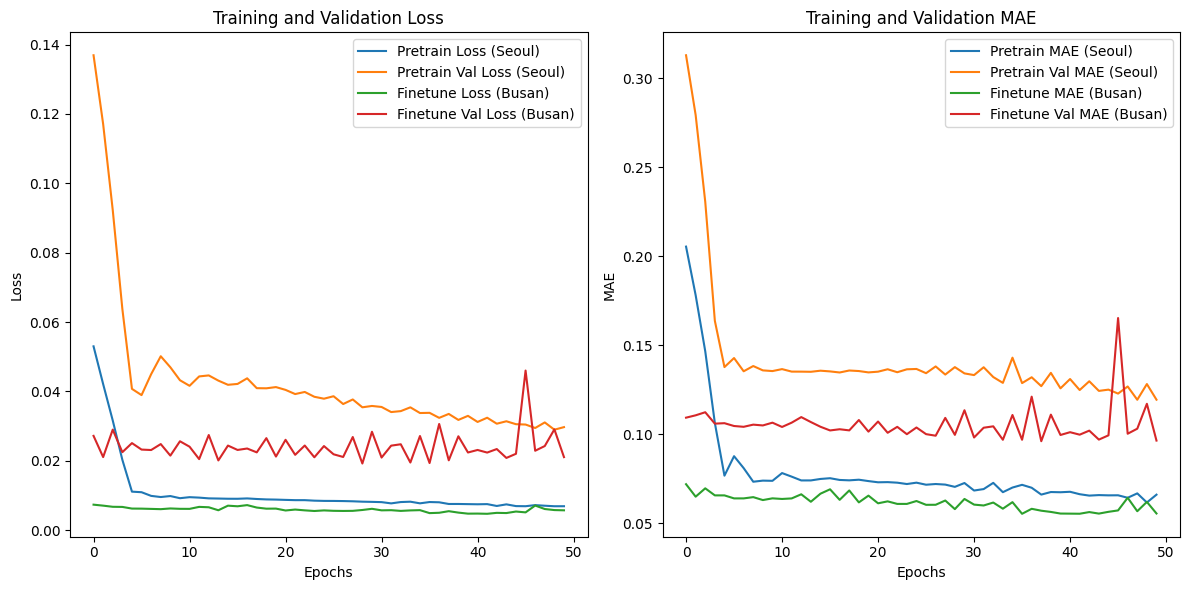

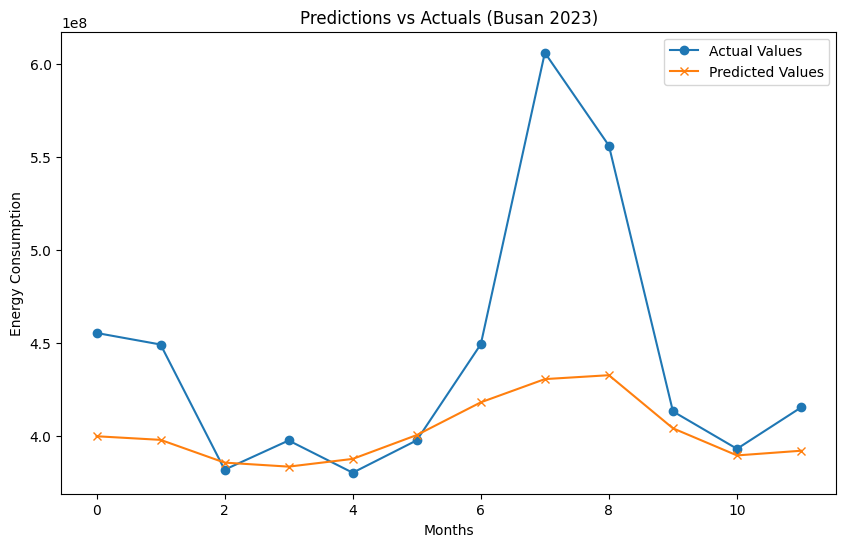

In [ ]:
import matplotlib.pyplot as plt

# 1. Plot training and validation loss during pretraining and fine-tuning
def plot_training_history(history_pretrain, history_finetune):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_pretrain.history['loss'], label='Pretrain Loss (Seoul)')
    plt.plot(history_pretrain.history['val_loss'], label='Pretrain Val Loss (Seoul)')
    plt.plot(history_finetune.history['loss'], label='Finetune Loss (Busan)')
    plt.plot(history_finetune.history['val_loss'], label='Finetune Val Loss (Busan)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history_pretrain.history['mae'], label='Pretrain MAE (Seoul)')
    plt.plot(history_pretrain.history['val_mae'], label='Pretrain Val MAE (Seoul)')
    plt.plot(history_finetune.history['mae'], label='Finetune MAE (Busan)')
    plt.plot(history_finetune.history['val_mae'], label='Finetune Val MAE (Busan)')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 2. Plot predictions vs actual values for Busan (2023)
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

# Call the functions to visualize training and results
plot_training_history(history_pretrain, history_finetune)
plot_predictions(actual_rescaled, predictions_rescaled)
